<style>
@import url(https://www.numfys.net/static/css/nbstyle.css);
</style>
<a href="https://www.numfys.net"><img class="logo" /></a>

# One-Dimensional Wave Packet Propagation
## Examples - Quantum Mechanics
<section class="post-meta">
By Jonas Tjemsland and Martin Duy Tat
</section>
Last edited: January 20th 2019
___

The aim of this example is to study numerical integration of the Schrödinger equation, propagation of wave packets, and scattering by and tunneling through a barrier. The initial conditions of the wave packets studied are represented by a Gaussian distribution of plane waves in an area in which $V=0$, i.e.

\begin{equation}
\Psi(x,t)=C\exp\left[-\frac{(x-x_s)^2}{2\sigma^2}\right]
		\exp\left[i(k_0x-\omega_0 t)\right].
\end{equation}

Here $C$ is a normalization constant, $x_s=\langle x\rangle_{t=0}$ is the initial displacement of the Gaussian, $\sigma$ is the width of the Gaussian (here the width at half maximum is $2\sqrt{2\ln 2}\sigma$, and $\Delta x = \sigma$), $k_0\equiv p_0/\hbar$ is the wave number and $\omega_0\equiv E/\hbar=\hbar k_0^2/2m$ is the wave's angular frequency. It can be shown that $\Psi(x,t)$ for $t>0$ and $V=0$ in fact must be

\begin{equation}
\Psi(x,t)=\frac{C\sigma}{\sqrt{\sigma^2+it\hbar/m}} e^{i[k_0x-\omega_0t]}\exp\left\{-\frac{(x-x_s-k_0\hbar t/m)^2}{2\sigma+ 2it\hbar /m}\right\}.
\end{equation}

The chosen representation is however a good approximation for the initial conditions, because the method used in this notebook require the initial state of the real part and the imaginary part at two different times, so we accept that this gives a small error.

We now import the necessary Python libraries, and set the plot parameters:

In [41]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc

# Set common figure parameters:
newparams = {'axes.labelsize': 14, 'axes.linewidth': 1, 'savefig.dpi': 300, 
             'lines.linewidth': 1.0, 'figure.figsize': (6, 2),
             'figure.subplot.wspace': 0.4,
             'ytick.labelsize': 10, 'xtick.labelsize': 10,
             'ytick.major.pad': 5, 'xtick.major.pad': 5,
             'legend.fontsize': 10, 'legend.frameon': False, 
             'legend.handlelength': 1.5, 'figure.dpi': 150}
plt.rcParams.update(newparams)

### Theory
The time-dependent Schödinger equation in one dimension reads,

\begin{equation}
i\hbar\frac{\partial}{\partial t}\Psi(x,t)=-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}\Psi(x,t)+V(x)\Psi(x,t).
\end{equation}

Using the notation $\Psi(x,t)=\Psi_R(x,t)+i\Psi_I(x,t)$, we and can split the Schrödinger equation into a real part,

\begin{equation}
-\hbar\frac{\partial}{\partial t}\Psi_I(x,t)=-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}\Psi_R(x,t)+V(x)\Psi_R(x,t),
\end{equation}

and an imaginary part,

\begin{equation}
\hbar\frac{\partial}{\partial t}\Psi_R(x,t)=-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}\Psi_I(x,t)+V(x)\Psi_I(x,t).
\end{equation}

We see that the above equations couple the real and imaginary parts of the Schrödinger equation.
Using an numerical approximation for the differentiation,

\begin{equation}
\frac{\partial}{\partial x}f(x)\approx\frac{f(x+\frac{\Delta x}{2})-f(x-\frac{\Delta x}{2})}{\Delta x},
\end{equation}

one can rewrite the imaginary and the real parts as

\begin{equation}
\begin{split}
		\Psi_I(x,t+\frac{\Delta t}{2})=\Psi_I(x,t-\frac{\Delta t}{2})-\Delta t \left[ \frac{V(x)}{\hbar}\Psi_R(x,t)-\frac{\hbar}{2m}\frac{\Psi_R(x+\Delta x,t)-2\Psi_R(x,t)+\Psi_R(x-\Delta x,t)}{(\Delta x)^2} \right],
	\end{split}
\end{equation}

and

\begin{equation}
\begin{split}
		\Psi_R(x,t+\Delta t)=\Psi_R(x,t)-\Delta t \left[ \frac{V(x)}{\hbar}\Psi_I(x,t+\frac{\Delta t}{2})- \frac{\hbar}{2m}\frac{\Psi_I(x + \Delta x,t+\frac{\Delta t}{2})-2\Psi_I(x,t+\frac{\Delta t}{2})+\Psi_I(x-\Delta x,t+\frac{\Delta t}{2})}{(\Delta x)^2}\right].
	\end{split}
\end{equation}

These equations easily lead to a procedure for finding $\Psi_I(x,t+\frac{\Delta t}{2})$ when $\Psi_I(x,t-\frac{\Delta t}{2})$ and $\Psi_R(x,t)$ is known, and likewise for finding $\Psi_R(x,t+\Delta t)$ when $\Psi_R(x,t)$ and $\Psi_I(x,t-\frac{\Delta t}{2})$ is known. This procedure naturally leads to an iterative procedure for propagating the wave packet numerically.



### Numerical stability
Since the Shrödinger equation is solved numerically, it is obvious that the solution only is an approximation of the true solution. Therefore, it is important to choose $\Delta t$ and $\Delta x$ as small as necessary to get the desired accuracy. However, it is also important to consider the relationship between $\Delta t$ and $\Delta x$. A poor choice of these parameters will not only decrease the accuracy, but the error may increase exponentially for each iteration.

Rearranging the formula for the numerical differentiation used above, we get

\begin{equation}
\Psi(x,t+\Delta t)-\Psi(x,t)=\Delta t \frac{\partial}{\partial t}\Psi(x,t).
\end{equation}

Since $\Delta t$ is only an approximation to an infinitesimal time, it is obvious that there will be an error when using this expression.
The relative change in the wave function $\Psi(x,t)$ in a time interval $\Delta t$ is given by

\begin{equation}
\frac{\Psi(x,t+\Delta t)-\Psi(x,t)}{\Psi(x,t)}=\Delta t\frac{\frac{-\hbar^2}{2m}\frac{\partial^2}{\partial x^2}\Psi(x,t)+V(x)\Psi(x,t)}{i\hbar\Psi(x,t)}.
\end{equation}

The largest possible spatial curvature for the wave function, $\frac{\partial^2}{\partial x^2}\Psi(x,t)$, will occur if the wave function changes from one peak to the neighbor peak across a distance $2\Delta x$. This implies that

\begin{equation}
\left| \frac{\partial^2}{\partial x^2}\Psi(x,t) \right| < \left|\frac{\Psi(x,t)}{(\Delta x)^2} \right| .
\end{equation}

$\Delta t$ must be chosen such that the fraction of which the wave function, $\Psi(x,t)$, changes during the time intervall $\Delta t$ is much smaller than 1. Such a relationship is derived from the two last equations,
 
\begin{equation}
\Delta t \ll \frac{2m\hbar(\Delta x)^2}{\hbar^2+2m(\Delta x)^2V_{max}},
\end{equation}

where $V_{max}$ is the maximum value of the potential in our domain. We will use this criteria to ensure numerical stability.

### Numerical implementation
All quantities are chosen in a dimensionless manner. The defined spatial area is $x\in [0,L]$, where the choice $L=20$ is made. Moreover, atomic units are used, which means $\hbar=1$ and $m=1$. The wave number is set to $k_0=20$, the width is set to $\sigma = 1$ and the initial displacement of the Gaussian is set to $x_s=5$. Using this choice, the whole wavepacket is included in the defined spacial area and is easily popagated half the defined width after $t_{max}=L/2v_g$, where $v_g$ is given by

\begin{equation}
\left. v_g=\frac{\partial \omega}{\partial k}\right|_{k_0}.
\end{equation}
    
We now define the constants chosen above:

In [42]:
L = 20.0                       # length of box
hbar = 1.0                     # hbar value, atomic units
m = 1.0                        # mass, atomic units
sigma = 1.0                    # width of the Gaussian
k0 = 20.0                      # the wave number
xs = 5.0                       # start displacement of the Gaussian
C=1/(1.77156762398*sigma)**0.5 # normalization constant
E = hbar**2*k0**2/(2*m)        # Energy of the wave packet
w = E/hbar                     # angular frequency
vg = hbar*k0/m                 # group velocity
tmax = L/(2*vg)                # time when the wave have propagated approx. half the box width

One must also define the time and length increment, and make a vector that holds all the $x$-values in the defined interval. Note that the critaria for numerical stability holds for this choice of parameter values.

In [43]:
dx = 0.01                # length increment
dt = 5*10**(-5)          # time increment
n = int(L/dx)            # number of x-values (=len(x))
x = np.linspace(0, L, n) # x-values on the x-axis

It is now time to calculate $\Psi_I(x,-\frac{\Delta t}{2})$ and $\Psi_R(x,0)$. Moreover, it is necessary to define a vector for the potential. We also want to calculate the probability distribution, $|\Psi(x,t)|^2=\Psi_I^2+\Psi_R^2$, already now.

By defining the imaginary and the real part of the wave function in such a way that $\Psi(0,t)\equiv\Psi(L,t)\equiv 0$, the same result as if the potential was infinity for $x\not\in(0,L)$ is obtained. In other words, it is a box with length $L$.

In [44]:
PsiI = C*np.exp(-(x-xs)**2/(2*sigma**2))*np.sin(k0*x-w*(-dt/2))  #\Psi_I(x,-dt/2)
PsiR = C*np.exp(-(x-xs)**2/(2*sigma**2))*np.cos(k0*x-w*0)        #\Psi_R(x,0)
probPsi = PsiI**2 + PsiR**2  #|\Psi|^2
V = np.array([0]*n)          # Potential
PsiI[1] = PsiI[n-1] = PsiR[0] = PsiR[n-1] = 0

One might want to normalize the wave function, thus deciding $C$. It is calculated by integrating the probability distribution $|\Psi(x,t)|^2=\Psi_I^2+\Psi_R^2$ over the box, and choosing $C$ such that $|\Psi(x,t)|^2=1$. The normalization will most certainly change slightly as the wave is propagating (and if different underlying constants are chosen) due to numerical errors. However, we assume that this change is negligible. Below we show that the wave function is close to normalized with the choice of $C$ defined above.

In [45]:
f = np.sum(probPsi*dx)
print('Normalization yields total probability equal to %0.15f' % f)

Normalization yields total probability equal to 0.999999999999306


### Initial Condition

We now plot the real and imaginary part of the wavefunction together with the probability distribution at $t=0$.

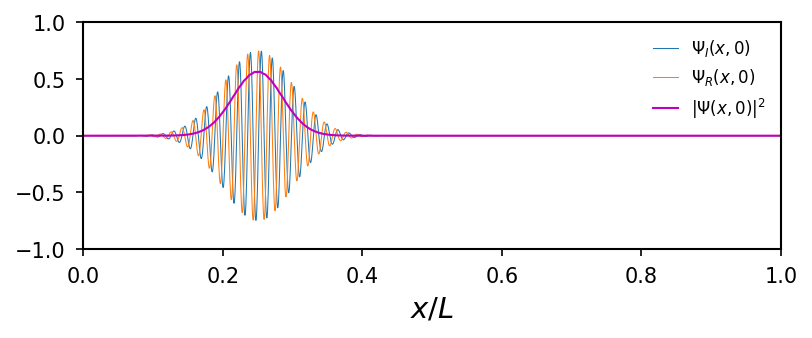

In [46]:
plt.plot(x/L, PsiI, label="$\Psi_I(x,0)$", linewidth=0.5)
plt.plot(x/L, PsiR, label="$\Psi_R(x,0)$", linewidth=0.5)
plt.plot(x/L, probPsi,'m', label="$|\Psi(x,0)|^2$")
plt.axis([0, 1,-1,1])
plt.legend(prop={'size':8})
plt.xlabel('$x/L$');

### Propagation with $V=0$

We now define a function ``timestep()`` which propagates the real and imaginary parts of the wavefunction forward in time with one time-step. 

In [48]:
def timestep(PsiI, PsiR, V, dx, dt):
    """ This function takes the current PsiI and PsiR and calculates the next value
    according to the theory section. 
    
    Input:
        PsiI    # Imaginary part of wavefunction at current timestep
        PsiR    # Real part of wavefunction at current timestep
        V       # Array with value of potential in the domain
        dx      # Grid size
        dt      # Size of time step
    
    Output:
        PsiI    # Imaginary part of wavefunction at next timestep
        PsiR    # Real part of wavefunction at next timestep
    """
    
    PsiI[1:n-1] = PsiI[1:n-1] - dt*(
        PsiR[1:n-1]*V[1:n-1]/hbar - hbar*(PsiR[2:n] - 2*PsiR[1:n-1] + PsiR[0:n-2])/(2*m*dx**2))
    PsiR[1:n-1] = PsiR[1:n-1] + dt*(
        PsiI[1:n-1]*V[1:n-1]/hbar - hbar*(PsiI[2:n] - 2*PsiI[1:n-1] + PsiI[0:n-2])/(2*m*dx**2))
    return PsiI, PsiR

If this calculation is done $t_{max}/\Delta t$ times, the wave packet is propagated approximately half the box width. Doing this for different values of $\sigma$, one can get an idea of how the wavepacket is dispersed as it propagates. One expects that the wave packet spreads out more if $\sigma$ is small.

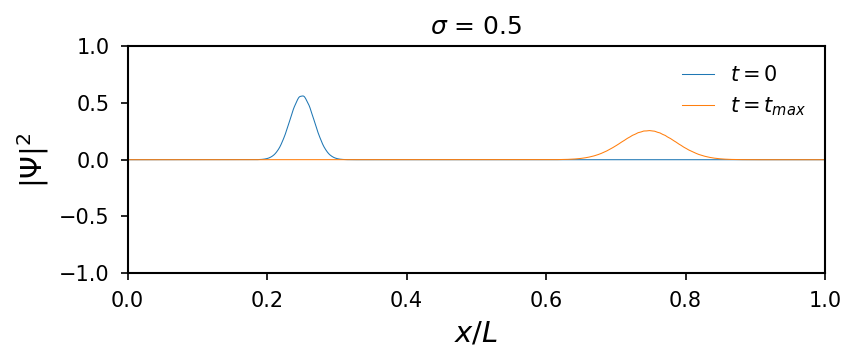

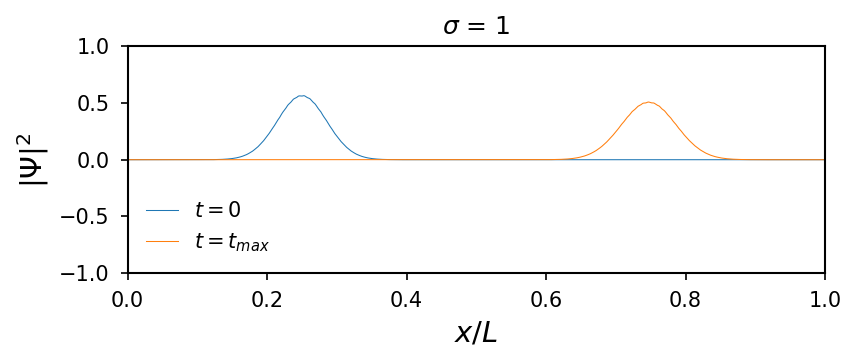

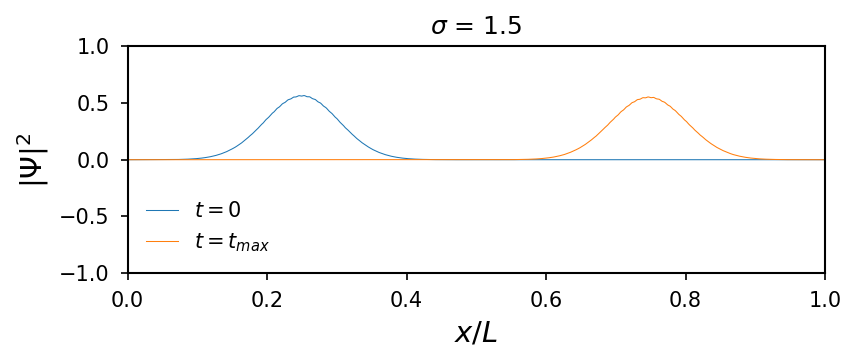

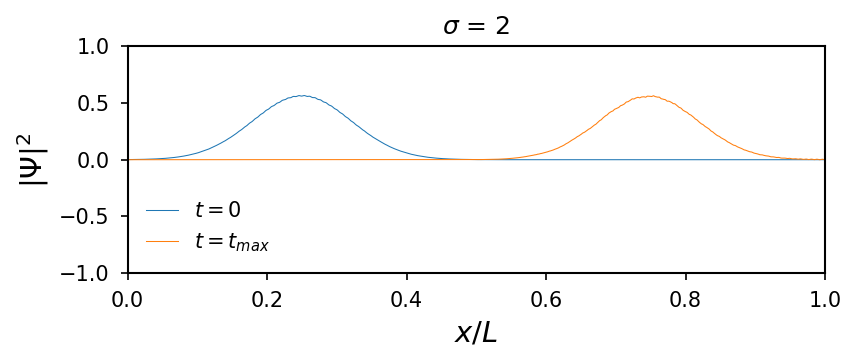

In [49]:
# Set values of sigma
sigmaval = [0.5 , 1, 1.5, 2]

for i in range(len(sigmaval)):

    PsiI = C*np.exp(-(x - xs)**2/(2*sigmaval[i]**2))*np.sin(k0*x - w*(-dt/2)) #\Psi_I(x,-dt/2)
    PsiR = C*np.exp(-(x - xs)**2/(2*sigmaval[i]**2))*np.cos(k0*x - w*0) #\Psi_I(x,0)
    PsiI[1] = PsiI[n-1] = PsiR[0] = PsiR[n-1] = 0
    
    # Plot for t=0
    plt.figure(i+1)
    probPsi = PsiR**2 + PsiI**2
    plt.plot(x/L, probPsi, linewidth=0.5, label='$t=0$')
    
    # Propagate wavefunction in time
    for j in range(int((tmax)/dt)):
        PsiI, PsiR = timestep(PsiI, PsiR, V, dx, dt)
    
    # Plot probability distribution at t = t_max
    probPsi = PsiR**2 + PsiI**2
    plt.plot(x/L, probPsi, linewidth=0.5, label='$t=t_{max}$')
    plt.legend(prop={'size':10})
    plt.axis([0, 1, -1, 1])
    plt.xlabel('$x/L$')
    plt.ylabel('$|\Psi|^2$')
    titletext = ('$\sigma$ = ' + str(sigmaval[i]))
    plt.title(titletext);

### Finite $V$

We now introduce a potential barrier in our system. When a potential barrier $V(x)$ is introduced, the wave packet will be partially reflected and partially transmitted. To start with, a square barrier is chosen such that

\begin{equation}
		V(x)=
		\begin{cases}
    			E/2,& \text{if } x\in[\frac{24}{50}L,\frac{26}{50}L],\\
			0,& \text{otherwise.}
        \end{cases}
\end{equation}

The script can easily be modified to work with any barrier by simply changing $V(x)$.

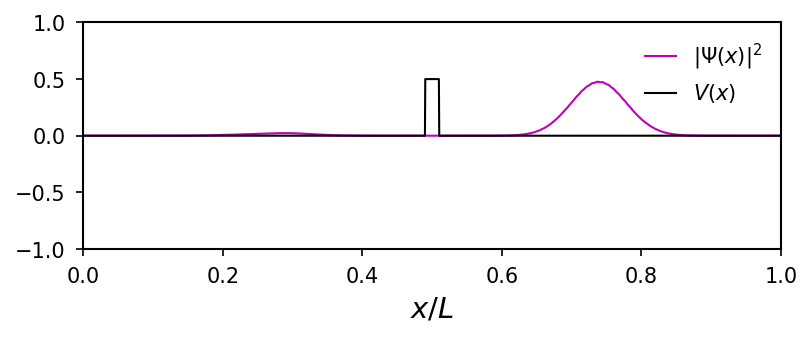

In [50]:
# Setting the potential
V = np.array([0]*n)
V0 = E/2
length = L/50
V[int(n/2-n*length/(2*L)):int(n/2+n*length/(2*L))] = V0

# Propagating wave function
PsiI = C*np.exp(-(x - xs)**2/(2*sigma**2))*np.sin(k0*x - w*(-dt/2)) #\Psi_I(x,-dt/2)
PsiR = C*np.exp(-(x - xs)**2/(2*sigma**2))*np.cos(k0*x - w*0) #\Psi_I(x,0)
PsiI[1] = PsiI[n-1] = PsiR[0] = PsiR[n-1] = 0

for j in range(int((tmax)/dt)):
    PsiI, PsiR = timestep(PsiI, PsiR, V, dx, dt)

probPsi = PsiI**2 + PsiR**2

# Plot probability distribution at t = t_max
plt.plot(x/L, probPsi,'m', label='$|\Psi(x)|^2$' )
plt.plot(x/L, V/E,'k', label='$V(x)$')
plt.axis([0, 1, -1, 1])
plt.xlabel('$x/L$')
plt.legend(prop={'size':10});

The transmission coefficient can be found by numerically by integrating the probability disturbution from $L/2$ to $L$, and likewise for the reflection coefficient by integrating from $0$ to $L/2$. The sum of the transmission and reflection coefficients should be equal to one.

In [51]:
T = sum(probPsi[int(n/2):int(n-1)]*dx)/sum(probPsi*dx)
R = sum(probPsi[0:int(n/2)]*dx)/sum(probPsi*dx)
print('Probability for transmission, T = %f' % T)
print('Probability for reflection, R = %f' % R)
print('Sum = %f' % (T + R))

Probability for transmission, T = 0.945668
Probability for reflection, R = 0.054332
Sum = 1.000000


One can also analyse how the transmission depends on different barrier properties. E.g. calculating the probabilities of transmission and reflection for 50 different barrier heights, $V_0$, from 0 to $3E/2$ with fixed width $L/20$.

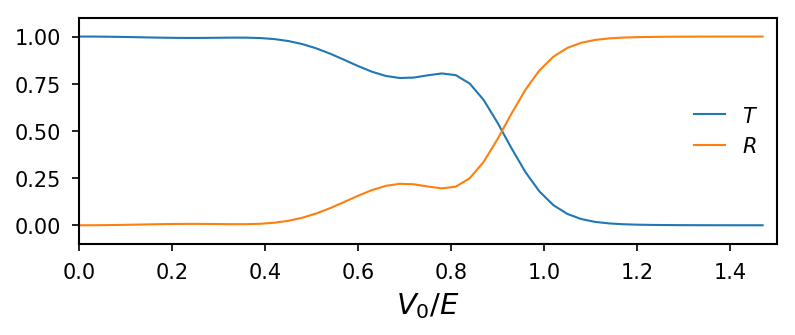

In [52]:
N = 50    # Number of different barriers
T = [0]*N # Define vector that holds the values for R and T
R = [0]*N
V0 = []

for q in range(N): # loop for each barrier property q
    
    # Setting the potential
    V = np.array([0]*n)
    length = L/50
    V0.append(3*E*q/(2*N))
    V[int(n/2-n*length/(2*L)):int(n/2+n*length/(2*L))] = V0[q]
    
    # Propagating wave function
    PsiI=C*np.exp(-(x - xs)**2/(2*sigma**2))*np.sin(k0*x - w*(-dt/2)) #\Psi_I(x,-dt/2)
    PsiR=C*np.exp(-(x - xs)**2/(2*sigma**2))*np.cos(k0*x - w*0)       #\Psi_R(x,0)
    PsiI[1] = PsiI[n-1] = PsiR[0] = PsiR[n-1] = 0
    
    for j in range(int((tmax)/dt)):
        PsiI, PsiR = timestep(PsiI, PsiR, V, dx, dt)
    
    probPsi = PsiI**2 + PsiR**2 #|\Psi|^2
    
    
    # Calculate transmission and reflection coefficients
    T[q] = sum(probPsi[int(n/2):int(n-1)]*dx)/sum(probPsi*dx)
    R[q] = sum(probPsi[0:int(n/2)]*dx)/sum(probPsi*dx)
    
# Plot the coefficients
plt.plot(np.array(V0)/E, T, label="$T$")
plt.plot(np.array(V0)/E, R, label="$R$")
plt.legend(loc=5)
plt.xlabel('$V_0/E$')
plt.axis([0, 1.5, -0.1, 1.1]);

Classically the particle would have a transmission coeffecient equal to $1$ when $E>V_0$ and $0$ when $E< V_0$. This is not the case in quantum mechanics, as seen in the plot above. Quantum mechanically, the probability of transmission is equal to $1$ when there are no barriers at all. As the barrier grows in strength, the transmission coefficient converges towards $0$. Notice however, that it never quite reaches $0$ and that there is a finite transmission probability even though $E < V_0$. This is the contraintuitive quantum mechanical effect known as tunneling. The sinusoidal tendency of the coefficients, which can also be showed analytically. For some wavelength to barrier width/strength relations the barrier seems "invisible" to the wave.

It is also interesting to calculate the probabilities of transmission and reflection for 50 different barrier widths from 0 to $L/20$ with fixed strength $V_0=9E/10$.

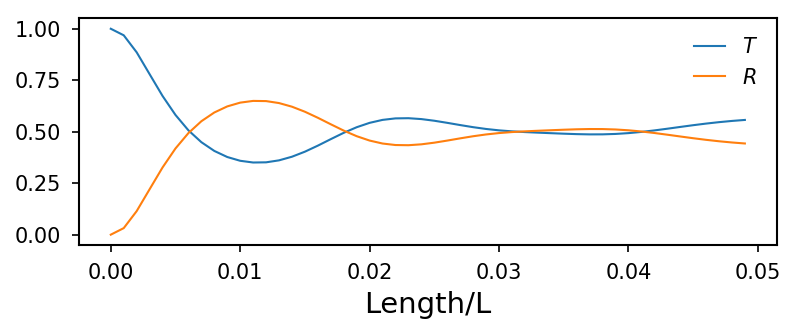

In [53]:
N = 50    # Number of different barriers
T = [0]*N # Define vector that holds the values for R and T
R = [0]*N
length = []

for q in range(0,N): # loop for each barrier property q
    
    # Setting the potential
    V = np.array([0]*n)
    V0 = 9*E/10
    length.append(q*L/(20*N))
    V[int(n/2-n*length[q]/(2*L)):int(n/2+n*length[q]/(2*L))] = V0
    
    # Propagating wave function
    PsiI = C*np.exp(-(x - xs)**2/(2*sigma**2))*np.sin(k0*x - w*(-dt/2)) #\Psi_I(x,-dt/2)
    PsiR = C*np.exp(-(x - xs)**2/(2*sigma**2))*np.cos(k0*x - w*0) #\Psi_I(x,0)
    PsiI[1] = PsiI[n-1] = PsiR[0] = PsiR[n-1] = 0
    
    for j in range(int((tmax)/dt)):
        PsiI, PsiR = timestep(PsiI, PsiR, V, dx, dt)
    
    probPsi = PsiI**2 + PsiR**2 #|\Psi|^2
        
    # Calculate transmission and reflection coefficients
    T[q] = sum(probPsi[int(n/2):int(n-1)]*dx)/sum(probPsi*dx)
    R[q] = sum(probPsi[0:int(n/2)]*dx)/sum(probPsi*dx)
    
# Plot
plt.plot(np.array(length)/L, T, label="$T$")
plt.plot(np.array(length)/L, R, label="$R$")
plt.legend()
plt.xlabel('Length/L');

Classically the transmission will always be $100\%$, since $E>V_0$. This is not the case quantum mechanically. Even though $E>V_0$ there is always a finite probability for reflection. Another interesting phenomenon to notice is that large wavepackets quickly spread out (not only because of dispersion) over a barrier or are divided into smaller ones. This is because parts of the wave packet is "caught" in the barrier itself as a consequence of reflections at the potential steps.

### Periodic Boundary Conditions

In the previous cases, the wave function was only propagated past a barrier in the middle. At the ends of the box the wave function was set to $0$, meaning that the potential outside the box is infinity. This causes the wave packet to be reflected back. To illustrate this, we will make an anitmation, using the functions defined below.

In [71]:
from matplotlib import animation
from IPython.display import HTML

# Set new figure parameters
newparams = {'axes.labelsize': 11, 'axes.linewidth': 0.5, 'savefig.dpi': 300, 
             'lines.linewidth': 1.0, 'figure.figsize': (2.5, 1.5),
             'ytick.labelsize': 5, 'xtick.labelsize': 5,}
plt.rcParams.update(newparams);

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(0, 1))
line, = ax.plot([], [], lw=1)

# Initialize wavefunction and set boundary conditions
PsiI = C*np.exp(-(x - xs)**2/(2*sigma**2))*np.sin(k0*x - w*(-dt/2)) #\Psi_I(x,-dt/2)
PsiR = C*np.exp(-(x - xs)**2/(2*sigma**2))*np.cos(k0*x - w*0) #\Psi_I(x,0)
V = [0]*n

probPsi = [PsiR**2 + PsiI**2]

# Number of time steps
tmax = 2*L/(2*vg)

# Propagate in time
for j in range(int((tmax)/dt)):
    PsiI, PsiR = timestep(PsiI, PsiR, V, dx, dt)
    
    probPsi.append(PsiR**2 + PsiI**2)

# Reduce the number of points to animate
probPsi = probPsi[0:-1:100]

# Initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# Animation function which updates figure data.  This is called sequentially
def animate(i):
    line.set_data(x/L, probPsi[i])
    return line,

# Call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(probPsi), interval=30, blit=True)

# Display the animation
plt.close(anim._fig)
HTML(anim.to_html5_video())

We now implement the ``timestep`` function to use periodic boundary conditions instead, i.e. $\Psi(x=0)=\Psi(x=L)$.

In [66]:
def timestep_periodic(PsiI, PsiR, V, dx, dt):
    """ This function takes the current PsiI and PsiR and calculates the next value
    according to the theory section. 
    
    Input:
        PsiI    # Imaginary part of wavefunction at current timestep
        PsiR    # Real part of wavefunction at current timestep
        V       # Array with value of potential in the domain
        dx      # Grid size
        dt      # Size of time step
    
    Output:
        PsiI    # Imaginary part of wavefunction at next timestep
        PsiR    # Real part of wavefunction at next timestep
    """
    
    PsiI[1:n-1] = PsiI[1:n-1] - dt*(
        PsiR[1:n-1]*V[1:n-1]/hbar - hbar*(PsiR[2:n] - 2*PsiR[1:n-1] + PsiR[0:n-2])/(2*m*dx**2))
    PsiR[1:n-1] = PsiR[1:n-1] + dt*(
        PsiI[1:n-1]*V[1:n-1]/hbar - hbar*(PsiI[2:n] - 2*PsiI[1:n-1] + PsiI[0:n-2])/(2*m*dx**2))
    
    PsiI[n-1] = PsiI[n-1] - dt*(
        PsiR[n-1]*V[n-1]/hbar - hbar*(PsiR[1] - 2*PsiR[n-1] + PsiR[n-2])/(2*m*dx**2))
    PsiR[n-1] = PsiR[n-1] + dt*(
        PsiI[n-1]*V[n-1]/hbar - hbar*(PsiI[1] - 2*PsiI[n-1] + PsiI[n-2])/(2*m*dx**2))
    
    PsiI[0] = PsiI[n-1]
    PsiR[0] = PsiR[n-1]
    
    return PsiI, PsiR

In [70]:
# Initialize wavefunction and set boundary conditions
PsiI = C*np.exp(-(x - xs)**2/(2*sigma**2))*np.sin(k0*x - w*(-dt/2)) #\Psi_I(x,-dt/2)
PsiR = C*np.exp(-(x - xs)**2/(2*sigma**2))*np.cos(k0*x - w*0) #\Psi_I(x,0)
V = [0]*n

probPsi = [PsiR**2 + PsiI**2]

# Number of time steps
tmax = 2*L/(2*vg)

# Propagate in time
for j in range(int((tmax)/dt)):
    PsiI, PsiR = timestep_periodic(PsiI, PsiR, V, dx, dt)
    
    probPsi.append(PsiR**2 + PsiI**2)

# Reduce the number of points to animate
probPsi = probPsi[0:-1:100]


# Call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(probPsi), interval=30, blit=True)

# Display the animation
plt.close(anim._fig)
HTML(anim.to_html5_video())

We see that the wave packet successfully passes through the wall at $x = L$ and reappears at $x = 0$, as it should when using periodic boundary conditions.

### Tunneling

Tunneling is the reason why alpha particles are able to escape from the nucleus of an atom, despite its lack of energy. According to classical mechanics, there is no way the alpha particle can penetrate the potential barrier that exists in the nucleus because of electrostatic attraction. However, as we will see in the animation below, there is a finite probability that the wave packet will penetrate the barrier.

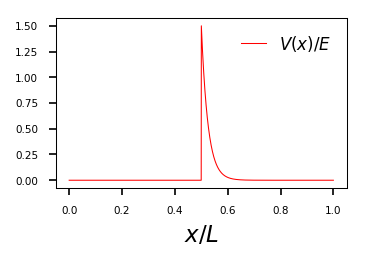

In [73]:
# Initialize wavefunction and set boundary conditions
PsiI = C*np.exp(-(x - xs)**2/(2*sigma**2))*np.sin(k0*x - w*(-dt/2)) #\Psi_I(x,-dt/2)
PsiR = C*np.exp(-(x - xs)**2/(2*sigma**2))*np.cos(k0*x - w*0) #\Psi_I(x,0)
V = zeros(n)
V[int(n/2)::] = 1.5*E*np.exp(-np.linspace(0, 20, int(n/2)))
probPsi = [PsiR**2 + PsiI**2]


# Plot potential
plt.plot(x/L ,V/E, 'r', label='$V(x)/E$', lw=0.5)
plt.legend(prop={'size':8})
plt.xlabel('$x/L$')

# Number of time steps
tmax = L/(2*vg)

# Propagate in time
for j in range(int((tmax)/dt)):
    PsiI, PsiR = timestep(PsiI, PsiR, V, dx, dt)
    
    probPsi.append(PsiR**2 + PsiI**2)

# Reduce the number of points to animate
probPsi = probPsi[0:-1:100]


# Initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# Animation function which updates figure data.  This is called sequentially
def animate(i):
    line.set_data(x/L, probPsi[i])
    return line,

# Call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(probPsi), interval=30, blit=True)

# Display the animation
plt.close(anim._fig)
HTML(anim.to_html5_video())

As we see, there is a finite transmission probability! This is a very rough model though, since the Coulomb potential is much higher and goes like $1/x$ and not exponentially. However, taking into account that the alpha particle hits the particle wall extremely often, increasing the probability of transmission, this example shows that the probability of alpha particle emission is noticeable.

### References

This script is a part of a numerical exercise in the subject FY2045 - Quantum
Mechanics I at NTNU - Norwegian University of Science and Technology. The exercise
was prepared by Tor Nordam

[1] Nordam, T.: Numerical exercise, FY2045 Quantum Mechanics, http://amokk.phys.ntnu.no/files/FY2045_2015/exercise15/numerics.pdf, 27.09.2015, [Downloaded: 01.10.2015]

[2] Hemmer, P.C.: Kvantemekanikk, tapir akademisk forlag, 5. utg. 2005, Trondheim

[3] Roundy, D.: http://physics.oregonstate.edu/~roundyd/COURSES/ph365x/366.html, [Downloaded: 23.10.2015]

[4] Øverbø, I.: Lecture notes 2,3 and 7, http://amokk.phys.ntnu.no/FY2045/documents/, [Downloaded: 09.2015]